# Wrangle and Analyze Data

Real-world data rarely comes clean. Using Python and its libraries, we will gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it for this project. The dataset that you will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates), also known as [WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs). WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. 

The goal is  to wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.



## Table of Contents
- [Introduction](#intro)
- [Gathering Data](#gather)
- [Assessing Data](#assess)
- [Cleaning Data](#clean)
- [Storing Data](#store)
- [Analyzing & Visualizing Data](#visual)
- [Webliography](#web)


<a id='intro'></a>


## Introduction

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import json
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import display
import re
%matplotlib inline
matplotlib.style.use('ggplot')

## Gathering Data
<a id='gather'></a>

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Manually downloading the Twitter Archive
df_twitter_archive = pd.read_csv('twitter_archive_enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
# Downloading data programmatically
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
data = requests.get(url)
with open(url.split('/')[-1], mode = 'wb') as file:
    file.write(data.content)

In [5]:
# Showing the data in the image predictions file
df_image_predictions = pd.read_csv('image-predictions.tsv', sep = '\t')
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

Reference: [StackOverflow](https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id)

In [7]:
df_list = []
error_list = []

start = time.time()

# Will add each available tweet json to df_list
for tweet_id in df_twitter_archive['tweet_id']:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended', wait_on_rate_limit = True,
                               wait_on_rate_limit_notify = True)._json 
        favorites = tweet['favorite_count'] # tweet's favorites
        retweets = tweet['retweet_count'] 
        user_followers = tweet['user']['followers_count'] 
        user_favourites = tweet['user']['favourites_count'] # user's favorites
        date_time = tweet['created_at'] # The date and time of the creation
        
        df_list.append({'tweet_id': int(tweet_id), 'favorites': int(favorites), 'retweets': int(retweets),
                        'user_followers': int(user_followers), 'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
        
    except Exception as e:
        print(str(tweet_id)+ " __ " + str(e))
        error_list.append(tweet_id)
        

end = time.time()
print(end - start)

888202515573088257 __ [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 __ [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 __ [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745 __ [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 __ [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 __ [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 __ [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130 __ [{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560 __ [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 __ [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984 __ [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 __ [{'code': 144, 'message': 'No status found with that ID.'}]
8373662848745717

_The total time was about 3310 seconds = 50 mins._

In [125]:
print("The list of tweets" ,len(df_list))
print("The list of tweets no found" , len(error_list))

The list of tweets 2331
The list of tweets no found 25


In [126]:
# Creating DataFrame for the tweets retrived
json_tweets = pd.DataFrame(df_list, columns = ['tweet_id', 'favorites', 'retweets', 'user_followers',
                                               'user_favourites', 'date_time'])

# saving JSON data
json_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index = False)

In [127]:
tweet_data = pd.read_csv('tweet_json.txt', encoding = 'utf-8')

__In the gathering part, we imported data from a existing csv file, downloaded tsv file programmaticaly, used Tweepy to query Twitter's API for additional data. Finally, imported all the data in workbook.__

## Assessing Data
<a id='assess'></a>

__Visual Assessment__

In [128]:
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [129]:
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [130]:
tweet_data

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,34892,7324,9005665,145305,2017-08-01 16:23:56+00:00
1,892177421306343426,30220,5468,9005665,145305,2017-08-01 00:17:27+00:00
2,891815181378084864,22749,3616,9005665,145305,2017-07-31 00:18:03+00:00
3,891689557279858688,38135,7509,9005665,145305,2017-07-30 15:58:51+00:00
4,891327558926688256,36411,8076,9005665,145305,2017-07-29 16:00:24+00:00
...,...,...,...,...,...,...
2326,666049248165822465,92,38,9005331,145299,2015-11-16 00:24:50+00:00
2327,666044226329800704,257,122,9005693,145299,2015-11-16 00:04:52+00:00
2328,666033412701032449,106,39,9005693,145299,2015-11-15 23:21:54+00:00
2329,666029285002620928,117,41,9005693,145299,2015-11-15 23:05:30+00:00


__Programmatic Assessment__

In [131]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [132]:
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [133]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [134]:
df_image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [135]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2331 non-null   int64 
 1   favorites        2331 non-null   int64 
 2   retweets         2331 non-null   int64 
 3   user_followers   2331 non-null   int64 
 4   user_favourites  2331 non-null   int64 
 5   date_time        2331 non-null   object
dtypes: int64(5), object(1)
memory usage: 109.4+ KB


In [136]:
tweet_data.describe()

,tweet_id,favorites,retweets,user_followers,user_favourites
count,2.331000e+03,2331.000000,2331.000000,2.331000e+03,2331.000000
mean,7.419079e+17,7285.032604,2577.707851,9.005676e+06,145301.344916
std,6.823170e+16,11315.010927,4359.825618,3.411261e+01,2.928232
min,6.660209e+17,0.000000,1.000000,9.005329e+06,145299.000000
25%,6.782670e+17,1261.500000,523.500000,9.005671e+06,145299.000000
50%,7.182469e+17,3157.000000,1202.000000,9.005679e+06,145299.000000
75%,7.986692e+17,8904.000000,2984.000000,9.005688e+06,145305.000000
max,8.924206e+17,149861.000000,73965.000000,9.005694e+06,145305.000000


In [137]:
df_image_predictions['jpg_url'].value_counts()

https://pbs.twimg.com/media/Ct2qO5PXEAE6eB0.jpg    2
https://pbs.twimg.com/media/Crwxb5yWgAAX5P_.jpg    2
https://pbs.twimg.com/media/Cveg1-NXgAASaaT.jpg    2
https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg    2
https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg    2
                                                  ..
https://pbs.twimg.com/media/CfkG_PMWsAAH0MZ.jpg    1
https://pbs.twimg.com/media/CaJRMPQWIAA1zL9.jpg    1
https://pbs.twimg.com/media/Cu7dg2RXYAIaGXE.jpg    1
https://pbs.twimg.com/media/CkXEu2OUoAAs8yU.jpg    1
https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg    1
Name: jpg_url, Length: 2009, dtype: int64

In [138]:
df_twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [139]:
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [140]:
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [141]:
df_twitter_archive[df_twitter_archive['rating_numerator'] > 20]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None


In [142]:
df_twitter_archive[df_twitter_archive.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [143]:
df_image_predictions[df_image_predictions.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [144]:
df_twitter_archive[df_twitter_archive['name'].apply(len) <= 2]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
393,825876512159186944,NaN,NaN,2017-01-30 01:21:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mo. No one will push him around in the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/825876512...,11,10,Mo,None,None,None,None
446,819015337530290176,NaN,NaN,2017-01-11 02:57:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bo. He was a very good ...,8.190048e+17,4.196984e+09,2017-01-11 02:15:36 +0000,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,None,None,None
449,819004803107983360,NaN,NaN,2017-01-11 02:15:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He was a very good First Doggo. 14...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,None,None,None
553,804026241225523202,NaN,NaN,2016-11-30 18:16:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's going to make me cry. 13/10 p...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/804026241...,13,10,Bo,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None


In [145]:
#Orignal tweets 

df_twitter_archive[df_twitter_archive['retweeted_status_id'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [146]:
df_image_predictions['p1'].value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
zebra                   1
leopard                 1
binoculars              1
military_uniform        1
cheetah                 1
Name: p1, Length: 378, dtype: int64

In [147]:
df_image_predictions['p2'].value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
menu                    1
shower_curtain          1
shower_cap              1
iPod                    1
birdhouse               1
Name: p2, Length: 405, dtype: int64

In [148]:
df_image_predictions['p3'].value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
standard_schnauzer     1
drumstick              1
maraca                 1
viaduct                1
Indian_elephant        1
Name: p3, Length: 408, dtype: int64

#### Quality
##### `df_twitter_archive` table
- _Source_ column format is bad and cannot be read easily.
- retweeted_status_timestamp, timestamp columns should be datetime instead of object (string).
- We may want to change this columns type (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id) to string because We don't want any operations on them.
- The *ratings_numerator* and *ratings_denominator* columns have invalid values.
- There are invalid names (a, an and less than 3 characters) in *name* column.
- There are retweeted tweets, and we do not want it.
- Change datatypes for columns tweet_id, timestamp, source, favorites, retweets, numerator & denominator.

##### `df_image_predictions` table
- Missing values from images dataset (2075 rows instead of 2356).
- Some tweets have 2 different tweet_id, that is retweets.

##### `tweet_data` table


#### Tidiness
- Dog stage is in 4 columns in `df_twitter_archive` (doggo, floofer, pupper, puppo), move into one column
- Merge `df_image_predictions` & `tweet_data` into `df_twitter_archive` table

## Cleaning Data
<a id='clean'></a>

In [149]:
# Create a copy of DataFrames for cleaning
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_predictions_clean = df_image_predictions.copy()
tweet_data_clean = tweet_data.copy()

### Tidiness

##### Define
Merge df_image_predictions & tweet_data into df_twitter_archive table.

##### Code

In [150]:
df_twitter_archive_clean = pd.merge(left=df_twitter_archive_clean,
                                 right=tweet_data_clean, left_on='tweet_id', right_on='tweet_id', how='inner')

In [151]:
df_twitter_archive_clean = df_twitter_archive_clean.merge(df_image_predictions_clean, on='tweet_id', how='inner')

##### Test

In [152]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2059 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2059 non-null   object 
 4   source                      2059 non-null   object 
 5   text                        2059 non-null   object 
 6   retweeted_status_id         72 non-null     float64
 7   retweeted_status_user_id    72 non-null     float64
 8   retweeted_status_timestamp  72 non-null     object 
 9   expanded_urls               2059 non-null   object 
 10  rating_numerator            2059 non-null   int64  
 11  rating_denominator          2059 non-null   int64  
 12  name                        2059 non-null   object 
 13  doggo                       2059 

##### Define
Dog stage is in 4 columns. Move doggo, floofer, pupper, puppo into *dog_stage* column

##### Code

In [153]:
#Some dogs have multiple stages, concatenate them.

df_twitter_archive_clean.loc[df_twitter_archive_clean.doggo == 'None', 'doggo'] = ''
df_twitter_archive_clean.loc[df_twitter_archive_clean.floofer == 'None', 'floofer'] = ''
df_twitter_archive_clean.loc[df_twitter_archive_clean.pupper == 'None', 'pupper'] = ''
df_twitter_archive_clean.loc[df_twitter_archive_clean.puppo == 'None', 'puppo'] = ''

df_twitter_archive_clean.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,,,,,1741
1,,,,puppo,23
2,,,pupper,,210
3,,floofer,,,7
4,doggo,,,,65
5,doggo,,,puppo,1
6,doggo,,pupper,,11
7,doggo,floofer,,,1


In [154]:
df_twitter_archive_clean['dog_stage'] = df_twitter_archive_clean.doggo + df_twitter_archive_clean.floofer + df_twitter_archive_clean.pupper + df_twitter_archive_clean.puppo
df_twitter_archive_clean.loc[df_twitter_archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo,pupper'
df_twitter_archive_clean.loc[df_twitter_archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo,puppo'
df_twitter_archive_clean.loc[df_twitter_archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo,floofer'

df_twitter_archive_clean.loc[df_twitter_archive_clean.dog_stage == '', 'dog_stage'] = 'None'

##### Test

In [155]:
df_twitter_archive_clean.dog_stage.value_counts()

None             1741
pupper            210
doggo              65
puppo              23
doggo,pupper       11
floofer             7
doggo,floofer       1
doggo,puppo         1
Name: dog_stage, dtype: int64

### Quality

##### Define
_Source_ column format is bad and can not be read easily. Make it clean and readable.

##### Code

In [156]:
df_twitter_archive_clean['source'] = df_twitter_archive_clean['source'].apply(lambda x : re.findall(r'>(.*)<', x)[0])

##### Test

In [157]:
df_twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,user_followers,user_favourites,date_time,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,,,,34892,7324,9005665,145305,2017-08-01 16:23:56+00:00,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,,,,30220,5468,9005665,145305,2017-08-01 00:17:27+00:00,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,,,,22749,3616,9005665,145305,2017-07-31 00:18:03+00:00,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,,,,38135,7509,9005665,145305,2017-07-30 15:58:51+00:00,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,,,,36411,8076,9005665,145305,2017-07-29 16:00:24+00:00,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,None


##### Define
The numerator and denominator columns have invalid values. Fix the ones which are not ratings

##### Code

In [158]:
tmp_rating = df_twitter_archive_clean[df_twitter_archive_clean.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")].text

for i in tmp_rating:
    x = df_twitter_archive_clean.text == i
    column_1 = 'rating_numerator'
    column_2 = 'rating_denominator'
    df_twitter_archive_clean.loc[x, column_1] = re.findall(r"\d+\.?\d*\/\d+\.?\d*\D+(\d+\.?\d*)\/\d+\.?\d*", i)
    df_twitter_archive_clean.loc[x, column_2] = 10

D:\Empty\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


##### Test

In [159]:
df_twitter_archive_clean[df_twitter_archive_clean.text.isin(tmp_rating)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,user_followers,user_favourites,date_time,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
445,802624713319034886,NaN,NaN,2016-11-26 21:26:58 +0000,Twitter for iPhone,"RT @dog_rates: ""Yep... just as I suspected. Yo...",7.776842e+17,4.196984e+09,2016-09-19 01:42:24 +0000,https://twitter.com/dog_rates/status/777684233...,11,10,None,,,,,0,2832,9005672,145305,2016-11-26 21:26:58+00:00,https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg,1,cocker_spaniel,0.253442,True,golden_retriever,0.162850,True,otterhound,0.110921,True,None
605,777684233540206592,NaN,NaN,2016-09-19 01:42:24 +0000,Twitter for iPhone,"""Yep... just as I suspected. You're not flossi...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/777684233...,11,10,None,,,,,10951,2832,9005672,145305,2016-09-19 01:42:24+00:00,https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg,1,cocker_spaniel,0.253442,True,golden_retriever,0.162850,True,otterhound,0.110921,True,None
812,747600769478692864,NaN,NaN,2016-06-28 01:21:27 +0000,Twitter for iPhone,This is Bookstore and Seaweed. Bookstore is ti...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747600769...,7,10,Bookstore,,,,,2250,540,9005675,145299,2016-06-28 01:21:27+00:00,https://pbs.twimg.com/media/CmAC7ehXEAAqSuW.jpg,1,Chesapeake_Bay_retriever,0.804363,True,Weimaraner,0.054431,True,Labrador_retriever,0.043268,True,None
863,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,Twitter for iPhone,"After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,14,10,None,,,,,33579,12670,9005677,145299,2016-06-08 02:41:38+00:00,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,3,golden_retriever,0.807644,True,kuvasz,0.101286,True,Labrador_retriever,0.023785,True,None
954,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,Twitter for iPhone,Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,13,10,None,,,,,3914,1483,9005679,145299,2016-04-21 02:25:47+00:00,https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg,1,Great_Dane,0.246762,True,Greater_Swiss_Mountain_dog,0.126131,True,Weimaraner,0.085297,True,None
988,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,Twitter for iPhone,This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,11,10,Bluebert,,,,,2285,200,9005681,145299,2016-04-03 01:36:11+00:00,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,1,Siberian_husky,0.396495,True,malamute,0.317053,True,Eskimo_dog,0.273419,True,None
1004,714258258790387713,NaN,NaN,2016-03-28 01:10:13 +0000,Twitter for iPhone,Meet Travis and Flurp. Travis is pretty chill ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/714258258...,8,10,Travis,,,,,2901,696,9005680,145299,2016-03-28 01:10:13+00:00,https://pbs.twimg.com/media/CemOGNjWQAEoN7R.jpg,1,collie,0.176758,True,Chesapeake_Bay_retriever,0.101834,True,beagle,0.101294,True,None
1126,703356393781329922,NaN,NaN,2016-02-26 23:10:06 +0000,Twitter for iPhone,This is Socks. That water pup w the super legs...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703356393...,2,10,Socks,,,,,1834,369,9005684,145299,2016-02-26 23:10:06+00:00,https://pbs.twimg.com/media/CcLS6QKUcAAUuPa.jpg,1,Border_collie,0.894842,True,collie,0.097364,True,English_springer,0.003037,True,None
1216,695064344191721472,NaN,NaN,2016-02-04 02:00:27 +0000,Twitter for iPhone,This may be the greatest video I've ever been ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695064344...,13,10,None,,,,,1534,559,9005684,145299,2016-02-04 02:00:27+00:00,https://pbs.twimg.com/ext_tw_video_thumb/69506...,1,seat_belt,0.522211,False,sunglasses,0.077552,False,ice_lolly,0.051774,False,None
1221,694352839993344000,NaN,NaN,2016-

##### Define
Clean decimal values in *rating_numerator*.

##### Code

In [160]:
# View tweets with decimal rating in 'text' column

df_twitter_archive_clean[df_twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

D:\Empty\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,user_followers,user_favourites,date_time,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
40,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,Twitter for iPhone,This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,,,,,41506,8605,9005665,145305,2017-07-08 00:28:19+00:00,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1,golden_retriever,0.943082,True,Labrador_retriever,0.032409,True,kuvasz,0.005501,True,None
548,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,,,,,17940,5976,9005671,145305,2016-10-13 23:23:56+00:00,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1,Pomeranian,0.467321,True,Persian_cat,0.122978,False,chow,0.102654,True,None
603,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,,,pupper,,6391,1553,9005672,145305,2016-09-20 00:24:34+00:00,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,clumber,0.946718,True,cocker_spaniel,0.015950,True,Lhasa,0.006519,True,pupper
1438,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,Twitter for iPhone,Here we have uncovered an entire battalion of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726...,26,10,None,,,,,1643,462,9005687,145299,2015-12-25 21:06:00+00:00,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1,kuvasz,0.438627,True,Samoyed,0.111622,True,Great_Pyrenees,0.064061,True,None


In [161]:
ratings = df_twitter_archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
ratings

,0,1
0,13,10
1,13,10
2,12,10
3,13,10
4,12,10
...,...,...
2054,5,10
2055,6,10
2056,9,10
2057,7,10


In [162]:
df_twitter_archive_clean['rating_numerator'] = ratings[0]

##### Test

In [163]:
df_twitter_archive_clean[df_twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

D:\Empty\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,user_followers,user_favourites,date_time,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
40,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,Twitter for iPhone,This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,13.5,10,Bella,,,,,41506,8605,9005665,145305,2017-07-08 00:28:19+00:00,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1,golden_retriever,0.943082,True,Labrador_retriever,0.032409,True,kuvasz,0.005501,True,None
548,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,9.75,10,Logan,,,,,17940,5976,9005671,145305,2016-10-13 23:23:56+00:00,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1,Pomeranian,0.467321,True,Persian_cat,0.122978,False,chow,0.102654,True,None
603,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,11.27,10,Sophie,,,pupper,,6391,1553,9005672,145305,2016-09-20 00:24:34+00:00,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,clumber,0.946718,True,cocker_spaniel,0.015950,True,Lhasa,0.006519,True,pupper
1438,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,Twitter for iPhone,Here we have uncovered an entire battalion of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726...,11.26,10,None,,,,,1643,462,9005687,145299,2015-12-25 21:06:00+00:00,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1,kuvasz,0.438627,True,Samoyed,0.111622,True,Great_Pyrenees,0.064061,True,None


##### Define
Fix Datatypes

##### Code

In [164]:
df_twitter_archive_clean['tweet_id'] = df_twitter_archive_clean['tweet_id'].astype(str)
df_twitter_archive_clean['timestamp'] = pd.to_datetime(df_twitter_archive_clean.timestamp)
df_twitter_archive_clean['source'] = df_twitter_archive_clean['source'].astype('category')
df_twitter_archive_clean['favorites'] = df_twitter_archive_clean['favorites'].astype(int)
df_twitter_archive_clean['retweets'] = df_twitter_archive_clean['retweets'].astype(int)
df_twitter_archive_clean['user_followers'] = df_twitter_archive_clean['user_followers'].astype(int)
df_twitter_archive_clean['dog_stage'] = df_twitter_archive_clean['dog_stage'].astype('category')
df_twitter_archive_clean['rating_numerator'] = df_twitter_archive_clean['rating_numerator'].astype(float)
df_twitter_archive_clean['rating_denominator'] = df_twitter_archive_clean['rating_denominator'].astype(float)

##### Test

In [165]:
df_twitter_archive_clean.dtypes

tweet_id                                   object
in_reply_to_status_id                     float64
in_reply_to_user_id                       float64
timestamp                     datetime64[ns, UTC]
source                                   category
text                                       object
retweeted_status_id                       float64
retweeted_status_user_id                  float64
retweeted_status_timestamp                 object
expanded_urls                              object
rating_numerator                          float64
rating_denominator                        float64
name                                       object
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
favorites                                   int32
retweets                                    int32
user_followers                              int32


##### Define
Delete columns no longer required.

##### Code

In [166]:
# Retweets ID:
df_twitter_archive_clean = df_twitter_archive_clean[pd.isnull(df_twitter_archive_clean.retweeted_status_id)]

#Duplicated tweet_id:
df_twitter_archive_clean = df_twitter_archive_clean.drop_duplicates()

# Without pictures:
df_twitter_archive_clean = df_twitter_archive_clean.dropna(subset = ['jpg_url'])

#Useless columns:
df_twitter_archive_clean = df_twitter_archive_clean.drop('retweeted_status_id', 1)
df_twitter_archive_clean = df_twitter_archive_clean.drop('retweeted_status_user_id', 1)
df_twitter_archive_clean = df_twitter_archive_clean.drop('retweeted_status_timestamp', 1)

#Since we have timestamp column, we do not need date_time:
df_twitter_archive_clean = df_twitter_archive_clean.drop('date_time', 1)

#Duplicates in dog_stage:
df_twitter_archive_clean = df_twitter_archive_clean.sort_values('dog_stage').drop_duplicates('tweet_id', keep = 'last')

##### Test

In [167]:
list(df_twitter_archive_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'favorites',
 'retweets',
 'user_followers',
 'user_favourites',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'dog_stage']

In [168]:
print(len(df_twitter_archive_clean))

1987


In [169]:
print(df_twitter_archive_clean.dog_stage.value_counts())

None             1682
pupper            203
doggo              62
puppo              22
doggo,pupper        9
floofer             7
doggo,puppo         1
doggo,floofer       1
Name: dog_stage, dtype: int64


##### Define
Delete image prediction columns. Also drop *in_reply_to_user_id, in_reply_to_user_id, user_favourites* column

##### Code

In [170]:
# Append the first True predection to the list 'perdictions' and the level appended to list 'confidence_level',
# Otherwise, will append NaN.
predictions = []
confidence_level = []

def prediction_func(dataframe):
    if dataframe['p1_dog'] == True:
        predictions.append(dataframe['p1'])
        confidence_level.append(dataframe['p1_conf'])
    elif dataframe['p2_dog'] == True:
        predictions.append(dataframe['p2'])
        confidence_level.append(dataframe['p2_conf'])
    elif dataframe['p3_dog'] == True:
        predictions.append(dataframe['p3'])
        confidence_level.append(dataframe['p3_conf'])
    else:
        predictions.append('NaN')
        confidence_level.append(0)

df_twitter_archive_clean.apply(prediction_func, axis=1)
df_twitter_archive_clean['prediction'] = predictions
df_twitter_archive_clean['confidence_level'] = confidence_level



# Delete columns
df_twitter_archive_clean = df_twitter_archive_clean.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
                                                    'p2_dog', 'p3', 'p3_conf', 'p3_dog'], 1)

df_twitter_archive_clean = df_twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id',
                                                    'user_favourites'], 1)

##### Test

In [171]:
list(df_twitter_archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'favorites',
 'retweets',
 'user_followers',
 'jpg_url',
 'dog_stage',
 'prediction',
 'confidence_level']

##### Define
Fix issues in name column

##### Code

In [172]:
df_twitter_archive_clean.name = df_twitter_archive_clean.name.str.replace('^[a-z]+', 'None')

##### Test

In [173]:
df_twitter_archive_clean.name.value_counts()

None        644
Oliver       10
Cooper       10
Charlie      10
Lucy          9
           ... 
Kallie        1
Jomathan      1
Jazzy         1
Kellogg       1
Aiden         1
Name: name, Length: 912, dtype: int64

In [174]:
df_twitter_archive_clean.name.sample(10)

1378       None
300       Pilot
1781       None
935        None
270        None
161       Benny
1517       None
1305      Derby
1624    Chesney
971       Sadie
Name: name, dtype: object

##### Define
Convert the Null values to None type

##### Code

In [175]:
df_twitter_archive_clean.loc[df_twitter_archive_clean['prediction'] == 'NaN', 'prediction'] = None
df_twitter_archive_clean.loc[df_twitter_archive_clean['rating_numerator'] == 'NaN', 'rating_numerator'] = 0

##### Test

In [176]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 63
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1987 non-null   object             
 1   timestamp           1987 non-null   datetime64[ns, UTC]
 2   source              1987 non-null   category           
 3   text                1987 non-null   object             
 4   expanded_urls       1987 non-null   object             
 5   rating_numerator    1987 non-null   float64            
 6   rating_denominator  1987 non-null   float64            
 7   name                1987 non-null   object             
 8   doggo               1987 non-null   object             
 9   floofer             1987 non-null   object             
 10  pupper              1987 non-null   object             
 11  puppo               1987 non-null   object             
 12  favorites           1987 non-null   

In [177]:
df_twitter_archive_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,user_followers,jpg_url,dog_stage,prediction,confidence_level
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,,,,,34892,7324,9005665,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,None,None,0.000000
1375,683852578183077888,2016-01-04 03:28:54+00:00,Twitter for iPhone,Say hello to Tiger. He's a penbroke (little do...,https://twitter.com/dog_rates/status/683852578...,10.0,10.0,Tiger,,,,,1866,330,9005686,https://pbs.twimg.com/media/CX2ISqSWYAAEtCF.jpg,None,toy_poodle,0.551352
1374,683857920510050305,2016-01-04 03:50:08+00:00,Twitter for iPhone,Meet Sadie. She fell asleep on the beach and h...,https://twitter.com/dog_rates/status/683857920...,10.0,10.0,Sadie,,,,,3658,1066,9005686,https://pbs.twimg.com/media/CX2NJmRWYAAxz_5.jpg,None,bluetick,0.174738
1373,684097758874210310,2016-01-04 19:43:10+00:00,Twitter for iPhone,Say hello to Lupe. This is how she sleeps. 10/...,https://twitter.com/dog_rates/status/684097758...,10.0,10.0,Lupe,,,,,3936,1358,9005686,https://pbs.twimg.com/media/CX5nR5oWsAAiclh.jpg,None,Labrador_retriever,0.627856
1372,684122891630342144,2016-01-04 21:23:02+00:00,Twitter for iPhone,Heartwarming scene of two pups that want nothi...,https://twitter.com/dog_rates/status/684122891...,11.0,10.0,None,,,,,1923,445,9005686,https://pbs.twimg.com/media/CX5-HslWQAIiXKB.jpg,None,None,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,744995568523612160,2016-06-20 20:49:19+00:00,Twitter for iPhone,This is Abby. She got her face stuck in a glas...,https://twitter.com/dog_rates/status/744995568...,9.0,10.0,Abby,,,,puppo,2846,586,9005675,https://pbs.twimg.com/media/ClbBg4WWEAMjwJu.jpg,puppo,Old_English_sheepdog,0.427481
340,819952236453363712,2017-01-13 17:00:21+00:00,Twitter for iPhone,This is Oliver. He has dreams of being a servi...,"https://www.gofundme.com/servicedogoliver,http...",13.0,10.0,Oliver,,,,puppo,5199,1135,9005670,https://pbs.twimg.com/media/C2EONHNWQAUWxkP.jpg,puppo,American_Staffordshire_terrier,0.925505
544,787717603741622272,2016-10-16 18:11:26+00:00,Twitter for iPhone,This is Tonks. She is a service puppo. Can hea...,https://twitter.com/dog_rates/status/787717603...,13.0,10.0,Tonks,,,,puppo,10072,2702,9005671,https://pbs.twimg.com/media/Cu6I9vvWIAAZG0a.jpg,puppo,German_shepherd,0.992339
14,889531135344209921,2017-07-24 17:02:04+00:00,Twitter for iPhone,This is Stuart. He's sporting his favorite fan...,https://twitter.com/dog_rates/status/889531135...,13.0,10.0,Stuart,,,,puppo,13757,1961,9005665,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg,puppo,golden_retriever,0.953442


## Storing Data
<a id='store'></a>
Store the clean DataFrame in a CSV file with the main one named `twitter_archive_master.csv`.

In [178]:
df_twitter_archive_clean.drop(df_twitter_archive_clean.columns[df_twitter_archive_clean.columns.str.contains('Unnamed',case = False)],axis = 1)

# Storing
df_twitter_archive_clean.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index=False)

In [179]:
df_twitter_archive_clean = pd.read_csv('twitter_archive_master.csv')
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1987 non-null   int64  
 1   timestamp           1987 non-null   object 
 2   source              1987 non-null   object 
 3   text                1987 non-null   object 
 4   expanded_urls       1987 non-null   object 
 5   rating_numerator    1987 non-null   float64
 6   rating_denominator  1987 non-null   float64
 7   name                1987 non-null   object 
 8   doggo               73 non-null     object 
 9   floofer             8 non-null      object 
 10  pupper              212 non-null    object 
 11  puppo               23 non-null     object 
 12  favorites           1987 non-null   int64  
 13  retweets            1987 non-null   int64  
 14  user_followers      1987 non-null   int64  
 15  jpg_url             1987 non-null   object 
 16  dog_st

## Analyzing, and Visualizing Data
<a id='visual'></a>

In [180]:
df = pd.read_csv('twitter_archive_master.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1987 non-null   int64  
 1   timestamp           1987 non-null   object 
 2   source              1987 non-null   object 
 3   text                1987 non-null   object 
 4   expanded_urls       1987 non-null   object 
 5   rating_numerator    1987 non-null   float64
 6   rating_denominator  1987 non-null   float64
 7   name                1987 non-null   object 
 8   doggo               73 non-null     object 
 9   floofer             8 non-null      object 
 10  pupper              212 non-null    object 
 11  puppo               23 non-null     object 
 12  favorites           1987 non-null   int64  
 13  retweets            1987 non-null   int64  
 14  user_followers      1987 non-null   int64  
 15  jpg_url             1987 non-null   object 
 16  dog_st

In [181]:
df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,user_followers,jpg_url,dog_stage,prediction,confidence_level
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,NaN,NaN,NaN,NaN,34892,7324,9005665,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,None,NaN,0.000000
1,683852578183077888,2016-01-04 03:28:54+00:00,Twitter for iPhone,Say hello to Tiger. He's a penbroke (little do...,https://twitter.com/dog_rates/status/683852578...,10.0,10.0,Tiger,NaN,NaN,NaN,NaN,1866,330,9005686,https://pbs.twimg.com/media/CX2ISqSWYAAEtCF.jpg,None,toy_poodle,0.551352
2,683857920510050305,2016-01-04 03:50:08+00:00,Twitter for iPhone,Meet Sadie. She fell asleep on the beach and h...,https://twitter.com/dog_rates/status/683857920...,10.0,10.0,Sadie,NaN,NaN,NaN,NaN,3658,1066,9005686,https://pbs.twimg.com/media/CX2NJmRWYAAxz_5.jpg,None,bluetick,0.174738
3,684097758874210310,2016-01-04 19:43:10+00:00,Twitter for iPhone,Say hello to Lupe. This is how she sleeps. 10/...,https://twitter.com/dog_rates/status/684097758...,10.0,10.0,Lupe,NaN,NaN,NaN,NaN,3936,1358,9005686,https://pbs.twimg.com/media/CX5nR5oWsAAiclh.jpg,None,Labrador_retriever,0.627856
4,684122891630342144,2016-01-04 21:23:02+00:00,Twitter for iPhone,Heartwarming scene of two pups that want nothi...,https://twitter.com/dog_rates/status/684122891...,11.0,10.0,None,NaN,NaN,NaN,NaN,1923,445,9005686,https://pbs.twimg.com/media/CX5-HslWQAIiXKB.jpg,None,NaN,0.000000


In [182]:
# Convert columns to their appropriate types and set the timestamp as an index

df['tweet_id'] = df['tweet_id'].astype(object)
df['timestamp'] = pd.to_datetime(df.timestamp)
df['source'] = df['source'].astype('category')
df['dog_stage'] = df['dog_stage'].astype('category')

df.set_index('timestamp', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1987 entries, 2017-08-01 16:23:56+00:00 to 2017-06-25 00:45:22+00:00
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tweet_id            1987 non-null   object  
 1   source              1987 non-null   category
 2   text                1987 non-null   object  
 3   expanded_urls       1987 non-null   object  
 4   rating_numerator    1987 non-null   float64 
 5   rating_denominator  1987 non-null   float64 
 6   name                1987 non-null   object  
 7   doggo               73 non-null     object  
 8   floofer             8 non-null      object  
 9   pupper              212 non-null    object  
 10  puppo               23 non-null     object  
 11  favorites           1987 non-null   int64   
 12  retweets            1987 non-null   int64   
 13  user_followers      1987 non-null   int64   
 14  jpg_url             1987 non-null   obje

In [183]:
df.describe()

,rating_numerator,rating_denominator,favorites,retweets,user_followers,confidence_level
count,1987.000000,1987.000000,1987.000000,1987.000000,1.987000e+03,1987.000000
mean,12.236930,10.511827,7972.249623,2341.348264,9.005677e+06,0.463913
std,41.544174,7.274245,11743.341732,4188.891331,3.435816e+01,0.339364
min,0.000000,7.000000,69.000000,11.000000,9.005329e+06,0.000000
25%,10.000000,10.000000,1705.000000,525.000000,9.005672e+06,0.140041
50%,11.000000,10.000000,3610.000000,1132.000000,9.005682e+06,0.457356
75%,12.000000,10.000000,9898.500000,2665.000000,9.005690e+06,0.776138
max,1776.000000,170.000000,149861.000000,73965.000000,9.005694e+06,0.999956


### Questions

#### 1) What is the most common dog type?

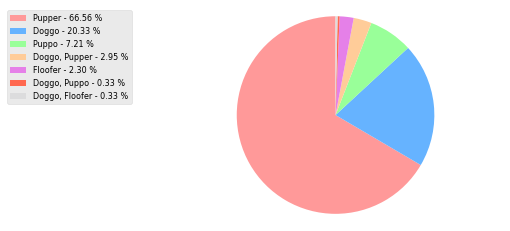

In [184]:
x = np.char.array(['Pupper', 'Doggo', 'Puppo', 'Doggo, Pupper', 'Floofer', 'Doggo, Puppo', 'Doggo, Floofer'])
y = np.array(list(df[df['dog_stage'] != 'None']['dog_stage'].value_counts())[0:7])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#E580E8','#FF684F','#DCDCDD']
porcent = 100.*y/y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.8)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
plt.axis('equal')

# Save the visualization as PNG file
plt.savefig('Most_common_dog.png', bbox_inches='tight')

**From the above visualization, Pupper is the most common dog in the dataset**

#### 2) What is the most common dog rating?

In [185]:
df_integer_ratings_14 = df[(df.rating_numerator <= 14) & (df.rating_numerator.apply(float.is_integer))]
subset_rating_counts = df_integer_ratings_14.groupby(['rating_numerator']).count()['tweet_id']

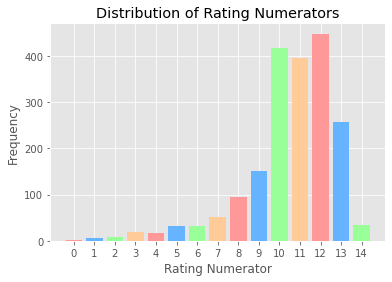

In [186]:
plt.bar(np.arange(15), subset_rating_counts, color=('#ff9999','#66b3ff','#99ff99','#ffcc99'))
plt.xticks(np.arange(15))
plt.xlabel('Rating Numerator')
plt.ylabel('Frequency')
plt.title('Distribution of Rating Numerators');

# Save the visualization as PNG file
plt.savefig('Most_common_rates.png', bbox_inches='tight')

**The most tweets are with a ratinig between 10-13**

#### 3) What is the relation between favorites & retweets?

D:\Empty\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


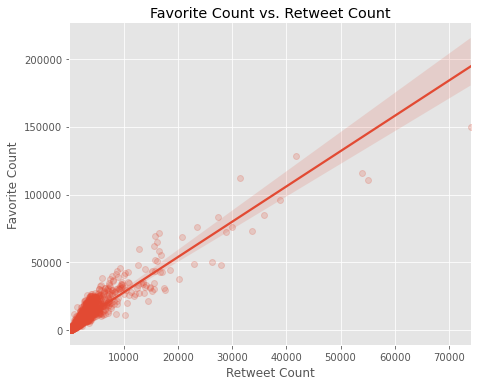

In [187]:
sns.lmplot(x="retweets", y="favorites", data=df, size = 5, aspect=1.3, scatter_kws={'alpha':1/5});

plt.title('Favorite Count vs. Retweet Count');
plt.xlabel('Retweet Count');
plt.ylabel('Favorite Count');

**There is a positive correlation between retweets & likes(favorites)**

#### 4) Which are the most popular dog names?

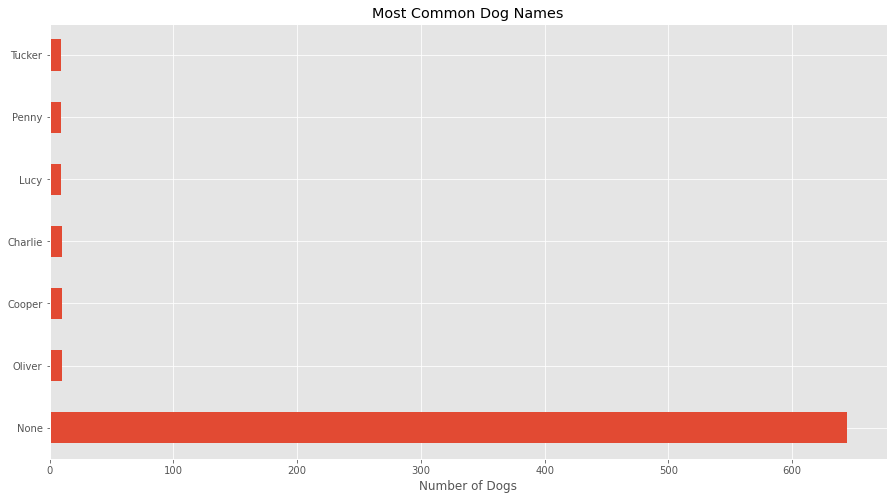

In [188]:
df.name.value_counts()[0:7].plot(kind='barh', figsize=(15,8), title='Most Common Dog Names').set_xlabel("Number of Dogs");

In [193]:
df.name.value_counts()

None        644
Oliver       10
Cooper       10
Charlie      10
Lucy          9
           ... 
Kallie        1
Jomathan      1
Jazzy         1
Kellogg       1
Aiden         1
Name: name, Length: 912, dtype: int64

**The most popular dog names are:**
- Oliver
- Cooper
- Charlie
- Lucy

## Webliography
<a id='web'></a>

- [WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs)
- [Twitter Profile](https://twitter.com/dog_rates)
- [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html)
- [requests](https://pypi.org/project/requests/)
- [tweepy](https://www.tweepy.org/)
- [StackOverflow](https://stackoverflow.com/)
- [Rules of Tidy Data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html)
- [seaborn](https://seaborn.pydata.org/)
- [Udacity Dataset & Knowlege Center](https://www.udacity.com/)